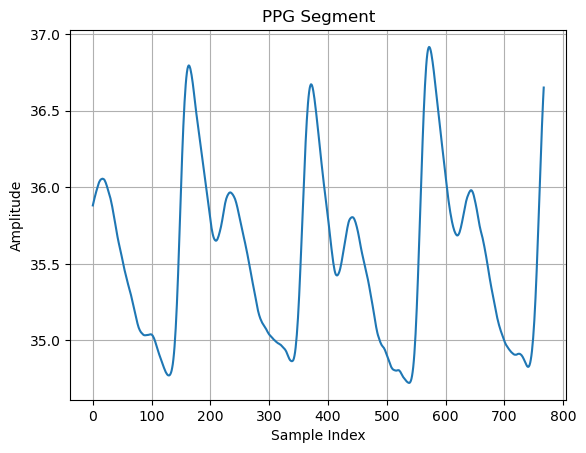

C:\Users\sonaa\.conda\envs\ppg_project\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\sonaa\.conda\envs\ppg_project\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\sonaa\.conda\envs\ppg_project\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\sonaa\.conda\envs\ppg_project\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


🧠 Stress Prediction:
   → Low Stress
   → Confidence: Low: 79.10%, High: 20.90%

😴 Drowsy/Burst Prediction:
   → Burst Activity
   → Confidence: Drowsy: 33.59%, Burst: 66.41%

⚠️ Models Disagree: Further analysis recommended.


In [16]:
# 1. Load packages
import joblib
import numpy as np
from PyEMD import EMD
from scipy.stats import skew
import pandas as pd
import matplotlib.pyplot as plt

# 2. Load trained models
stress_model = joblib.load(r"C:\Users\sonaa\clean_mwl_classifier.joblib")  
drowsy_burst_model = joblib.load(r"C:\Users\sonaa\drowsy_burst_mlp_model.joblib")  

# 3. Define dual classification function
def classify_ppg_dual(ppg_segment, stress_model, drowsy_model):
    emd = EMD(spline_kind='cubic', MAX_ITERATION=100)
    imfs = emd(ppg_segment, max_imf=10)

    if imfs.shape[0] < 2:
        print("Not enough IMFs. Try different signal.")
        return None

    imf1 = imfs[0]

    # Matching feature vector for both models
    features = np.array([
        np.mean(imf1),
        np.min(imf1),
        np.max(imf1),
        skew(imf1)
    ]).reshape(1, -1)

    # Predict stress
    stress_pred = stress_model.predict(features)[0]
    stress_proba = stress_model.predict_proba(features)[0]

    # Predict drowsy/burst
    drowsy_pred = drowsy_model.predict(features)[0]
    drowsy_proba = drowsy_model.predict_proba(features)[0]

    return (stress_pred, stress_proba), (drowsy_pred, drowsy_proba)

# 4. Load a new PPG segment
df = pd.read_csv(r"D:\PPG Dataset\Low_MWL\Low_MWL\p10l.csv")  # Update path if needed
ppg_segment = df.iloc[:768, 0].dropna().values

# Optional: Visualize signal
plt.plot(ppg_segment)
plt.title("PPG Segment")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# 5. Run prediction
result = classify_ppg_dual(ppg_segment, stress_model, drowsy_burst_model)

# 6. Output results with verification
if result:
    (stress_result, stress_proba), (drowsy_result, drowsy_proba) = result

    stress_text = "High Stress" if stress_result else "Low Stress"
    drowsy_text = "Burst Activity" if drowsy_result else "Drowsy"

    print("Stress Prediction:")
    print(f"   → {stress_text}")
    print(f"   → Confidence: Low: {stress_proba[0]*100:.2f}%, High: {stress_proba[1]*100:.2f}%\n")

    print("Drowsy/Burst Prediction:")
    print(f"   → {drowsy_text}")
    print(f"   → Confidence: Drowsy: {drowsy_proba[0]*100:.2f}%, Burst: {drowsy_proba[1]*100:.2f}%\n")

    # Cross-verification
    if stress_result == drowsy_result:
        print("Double Confirmation: Stress and Burst/Drowsy models agree.")
    else:
        print("⚠️ Models Disagree: Further analysis recommended.")
else:
    print("IMF extraction failed.")
